In [7]:
%matplotlib inline
import os, pickle, string
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

font_path = "/home/zhoujb/local/font/Times New Roman.ttf"
mpl.font_manager.fontManager.addfont(font_path)
prop = mpl.font_manager.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

RAW_PATH = "/data2/zhoujb/project/cowpea_project/rawData/"
SNP_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/snpDir/"
CLUSTER_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/SNPMMSeqCluster/"
RES_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/Result/"
FIG_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/plotFigure/"

In [2]:
#raw_phenos = pd.read_excel(os.path.join(RAW_PATH, "Phenotypes for GWAS-upload public database.xlsx"), index_col="Accessions")
raw_phenos_1 = pd.read_excel(os.path.join(RAW_PATH, "Phenotypes for GWAS-upload public database.xlsx"), index_col="Accessions")
raw_phenos_2 = pd.read_excel(os.path.join(RAW_PATH, "BMK21067-AK808-data-2.xlsx"), index_col="BMK-ID")
raw_phenos_2 = raw_phenos_2[['HZ Pod Cellulose (mg/g)', 'GZ Pod Cellulose (mg/g)', 'HZ Seed Cellulose (mg/g)', 'GZ Seed Cellulose (mg/g)']].copy()
raw_phenos = raw_phenos_1.merge(raw_phenos_2, how='left', left_index=True, right_index=True)

raw_phenos = raw_phenos.drop(columns="ID")
raw_phenos = raw_phenos.replace({"-":np.nan})
raw_phenos = raw_phenos.dropna(axis=0, how="all")
raw_phenos = raw_phenos.rename(columns={'HZ-Pod length':'HZ-PL', 'GZ-Pod length':'GZ-PL', 
                                        'HZ Pod Sugar content (mg/g)':'HZ-PSugar','GZ Pod Sugar content  (mg/g)':'GZ-PSugar', 
                                        'HZ Pod Starch content(mg/g)':'HZ-PStarch','GZ Pod Strach Content (mg/g)':'GZ-PStarch', 
                                        'HZ Pod Protein content(g/Kg)':'HZ-PProtein','GZ Pod protein  (g/Kg)':'GZ-PProtein', 
                                        'HZ Seed Sugar (mg/g)':'HZ-SSuger','GZ Seed Sugar (mg/g)':'GZ-SSuger', 
                                        'HZ Seed Starch (mg/g)':'HZ-SStarch','GZ Seed Starch (mg/g)':'GZ-SStarch', 
                                        'HZ Seed Protein (g/kg)':'HZ-SProtein','GZ Seed Protein (g/kg)':'GZ-SProtein', 
                                        'Pod shattering':'PS', 'HZ Pod Cellulose (mg/g)':"HZ-PC", 'GZ Pod Cellulose (mg/g)':"GZ-PC",
                                        'HZ Seed Cellulose (mg/g)':"HZ-SC", 'GZ Seed Cellulose (mg/g)':"GZ-SC"})

samples_score_info = pd.read_table(os.path.join(RES_PATH, "Samples_Score_Info.tsv"), index_col="Sample")
samples_score_info = samples_score_info.drop(columns=[ 'Class', 'Mis_Hap_Num'])
samples_score_info = samples_score_info.rename(columns={'Hap_Score.by_Total_pop':'Total_score', 
                                                        'Hap_Score.by_VL_pop':'VL_score',
                                                        'Hap_Score.by_G_pop':'G_score',
                                                        'Hap_Score.by_VC_pop':'VC_score'})
samples_score_info = samples_score_info[["Total_score"]]

inte_sample_list = list(set(raw_phenos.index).intersection(samples_score_info.index.to_list()))
raw_phenos = raw_phenos.loc[inte_sample_list]
samples_score_info = samples_score_info.loc[inte_sample_list]

detail_info = pd.read_excel(os.path.join(RAW_PATH, "Detail_information_344.xlsx"), index_col="Genotype No.")
detail_info["Type"] = detail_info["Types"].map({'Grain':"G", 'V-landrace':"VL", '-':"NA", 'V-cultivar':"VC"})
detail_info = detail_info.loc[inte_sample_list]
detail_info = detail_info[["Type"]]

phenos_add_score = pd.concat([raw_phenos, samples_score_info, detail_info], axis=1)

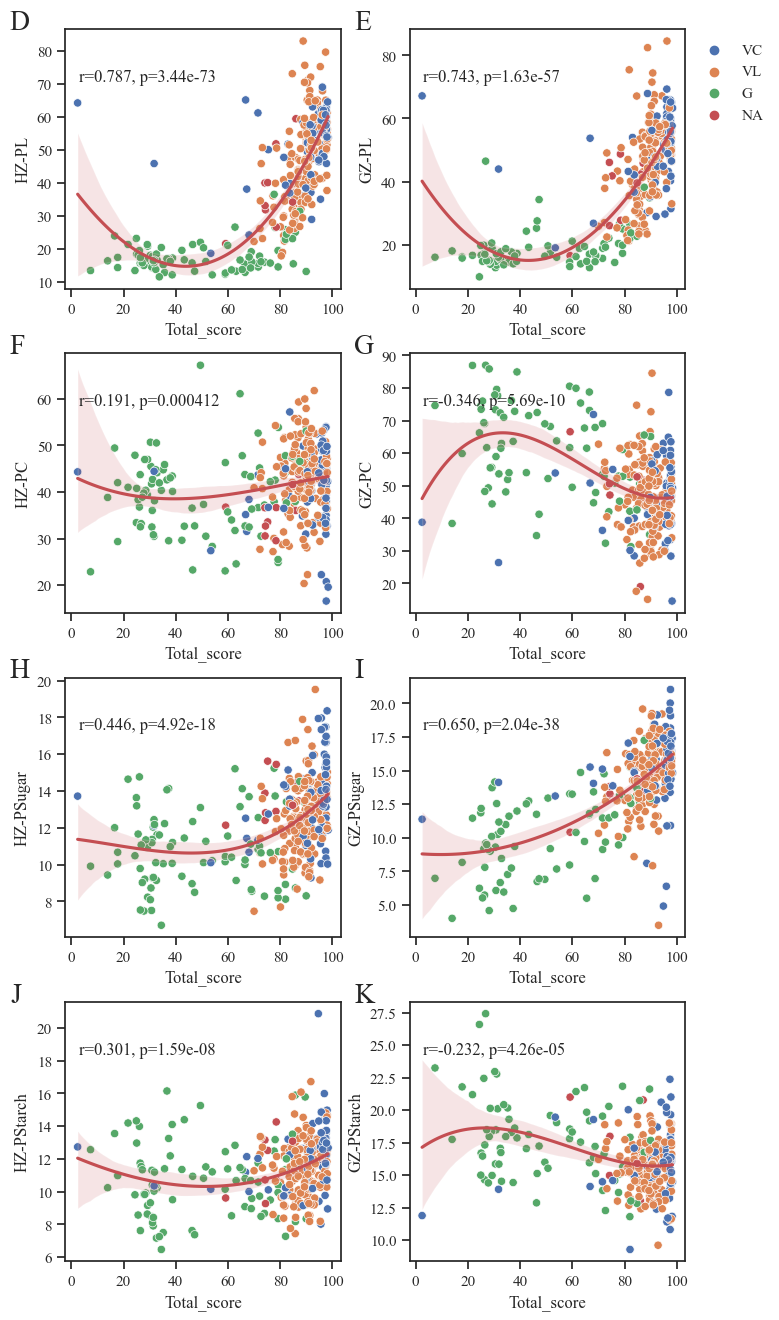

In [16]:
hz_col = ['HZ-PL', 'GZ-PL','HZ-PC', 'GZ-PC', 'HZ-PSugar', 'GZ-PSugar', 'HZ-PStarch', 'GZ-PStarch']
sns.set(font_scale=1, style="ticks")

def letter_annotation(ax, xoffset, yoffset, letter):

    mpl.rcParams['font.family'] = prop.get_name()
    mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
    ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
            size=20, weight='bold')

item_list = list("DEFGHIJK")

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 16))
fig.subplots_adjust(wspace=0.25, hspace=0.25)
for num in range(len(hz_col)):
    mpl.rcParams['font.family'] = prop.get_name()
    mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
    
    if num == 1:
        sns.scatterplot(x="Total_score", y=hz_col[num], hue="Type", data=phenos_add_score, 
                        ax=axes[num//2, num%2], hue_order=['VC', 'VL', 'G', 'NA'])
        axes[num//2, num%2].legend(bbox_to_anchor=(1, 1), frameon=False)
    else:
        sns.scatterplot(x="Total_score", y=hz_col[num], hue="Type", data=phenos_add_score, 
                        ax=axes[num//2, num%2],  hue_order=['VC', 'VL', 'G', 'NA'], legend=None)
    sns.regplot(x="Total_score", y=hz_col[num], data=phenos_add_score, 
                ax=axes[num//2, num%2], ci=95, order=3, scatter=False, color="r")

    r, pvalue = stats.spearmanr(phenos_add_score["Total_score"].values, phenos_add_score[hz_col[num]].values, nan_policy="omit")

    #if pvalue < 0.001:
        #anno_label = 'r={:.3f}, p<0.001'.format(r)
    #else:
        #anno_label = 'r={:.3f}, p={:.3f}'.format(r, pvalue)
    anno_label = 'r={:.3f}, p={:.3g}'.format(r, pvalue)

    axes[num//2, num%2].text(.05, .8, anno_label, transform=axes[num//2, num%2].transAxes, font_properties=prop)

    letter_annotation(axes[num//2, num%2], -0.2, 1., item_list[num])
    

plt.savefig(os.path.join(FIG_PATH, 'Fig_1D-K_corr_scatter.pdf'), format='pdf', bbox_inches='tight', transparent=True)